<a href="https://colab.research.google.com/github/SJC2212/CodeSoft/blob/main/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 414, number of negative: 386
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5156
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517500 -> initscore=0.070029
[LightGBM] [Info] Start training from score 0.070029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ctDNA Model Accuracy: 0.515
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       105
           1       0.49      0.59      0.54        95

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



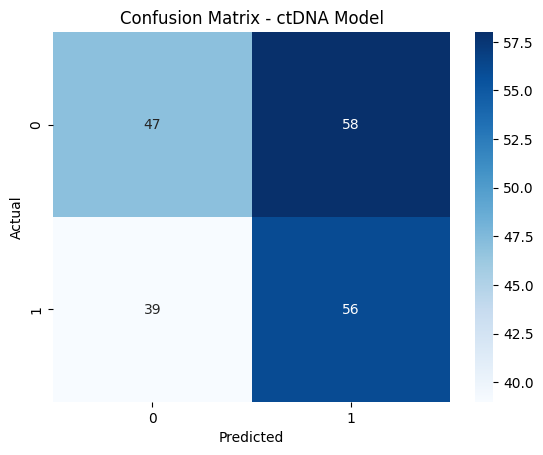

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


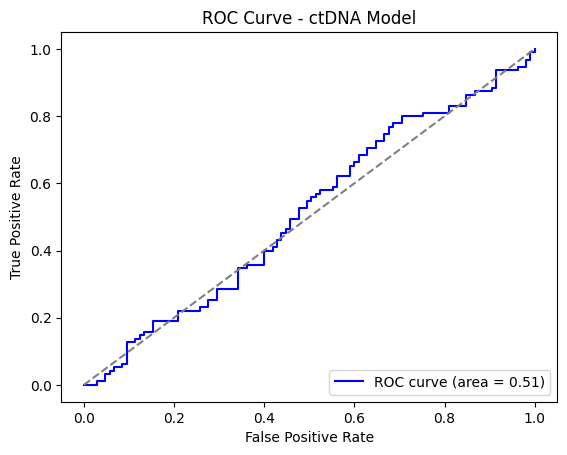

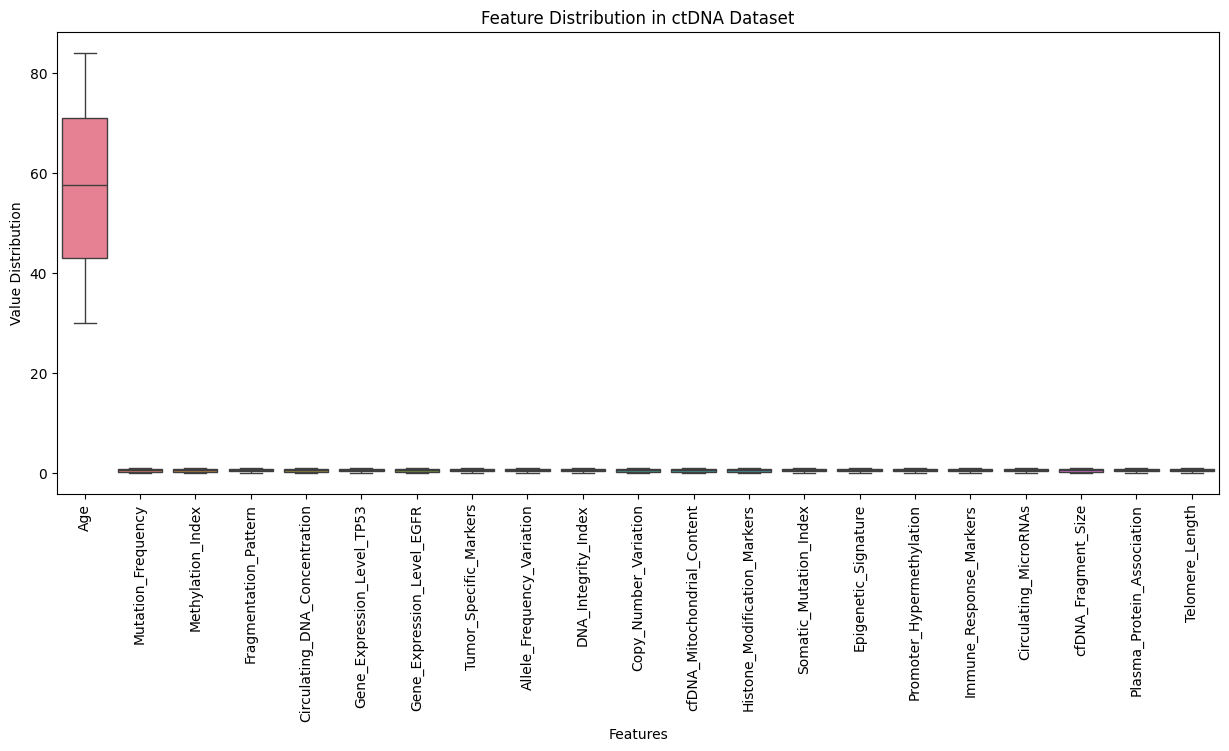

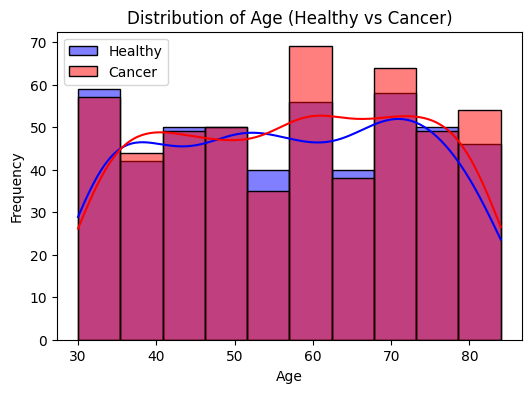

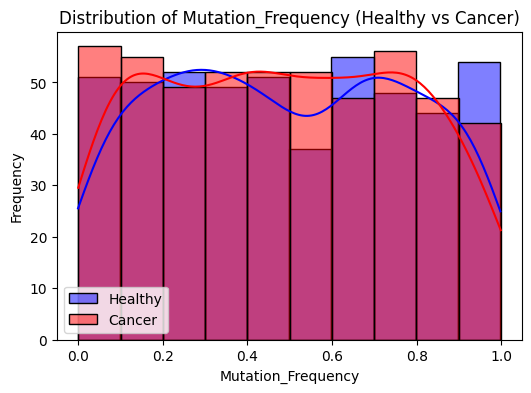

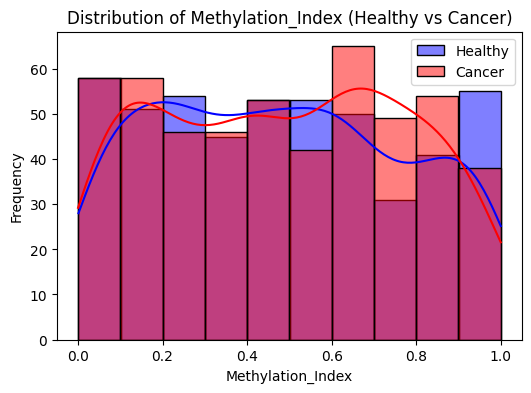

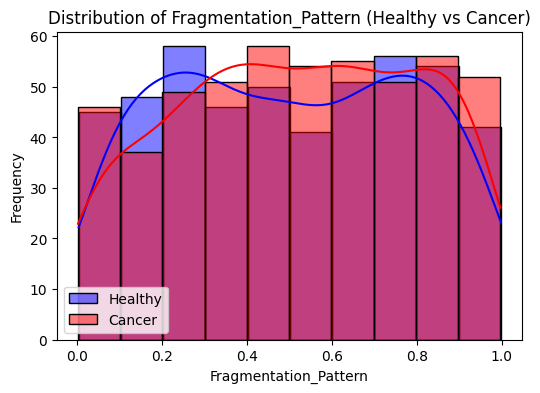

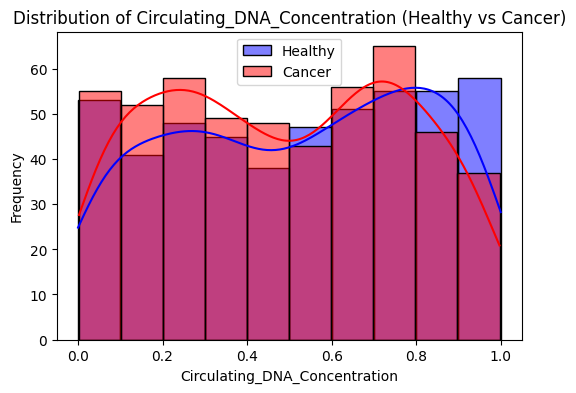

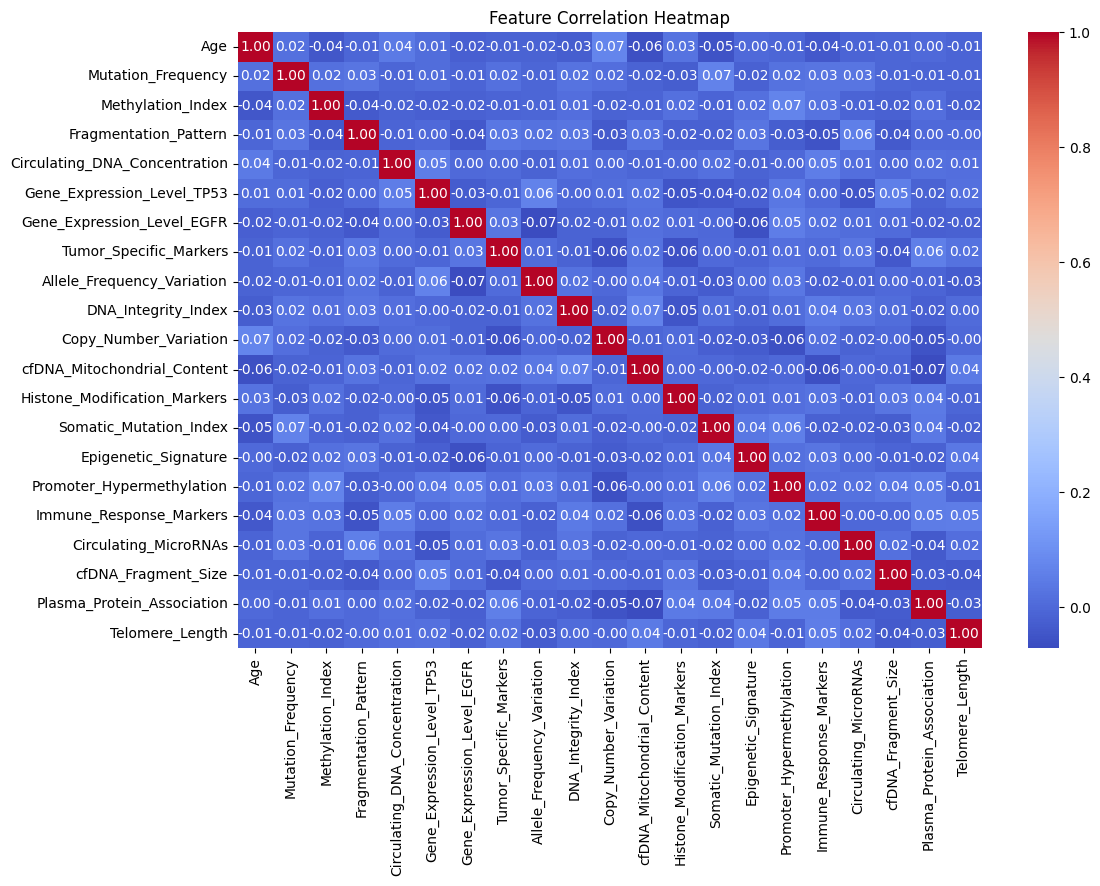

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lightgbm import LGBMClassifier  # Using LightGBM

# === Utility Functions ===
def load_ctdna_dataset(ctdna_file_path):
    """
    Load the ctDNA dataset from the specified file path.
    """
    return pd.read_csv(ctdna_file_path)


def extract_images(zip_path, extract_path):
    """
    Extract the ZIP file containing lung images.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)


def load_images(image_folder_path, target_size=(128, 128)):
    """
    Load and preprocess the images in the given directory.
    """
    images = []
    labels = []
    for class_name in os.listdir(image_folder_path):
        class_path = os.path.join(image_folder_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = imread(img_path)
                img_resized = resize(img, target_size, anti_aliasing=True)
                images.append(img_resized)
                labels.append(class_name)

    return np.array(images), np.array(labels)

# === Main Code ===
# Paths for datasets
ctdna_file_path = 'ctdna_data_with_patient_info.csv'
image_zip_path = 'lung_images_dataset.zip'
image_folder_path = 'lung_images_dataset'

# Extract lung images dataset
if not os.path.exists(image_folder_path):
    extract_images(image_zip_path, image_folder_path)

# === Lung Cancer Prediction Using ctDNA Dataset ===
# Load and preprocess ctDNA data
ctdna_data = load_ctdna_dataset(ctdna_file_path)
ctdna_data = ctdna_data.drop(columns=['Patient_ID'])

# Extract features and labels
X_ctdna = ctdna_data.drop(columns=['target'])  # Features
y_ctdna = ctdna_data['target']  # Labels

# Encode target labels
y_ctdna = LabelEncoder().fit_transform(y_ctdna)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_ctdna, y_ctdna, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the LightGBM model (Replacing XGBoost)
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# Predict and evaluate the model
ctdna_predictions = lgbm_model.predict(X_test)
print("ctDNA Model Accuracy:", accuracy_score(y_test, ctdna_predictions))
print(classification_report(y_test, ctdna_predictions))

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, ctdna_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - ctDNA Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ctDNA Model')
plt.legend(loc='lower right')
plt.show()

# Improved Feature Comparison: Healthy vs Cancer Patients
healthy = ctdna_data[ctdna_data['target'] == 0].drop(columns=['target'])
cancer = ctdna_data[ctdna_data['target'] == 1].drop(columns=['target'])

# Boxplot for multiple features
plt.figure(figsize=(15, 6))
sns.boxplot(data=ctdna_data.drop(columns=['target']))
plt.xticks(rotation=90)
plt.title("Feature Distribution in ctDNA Dataset")
plt.xlabel("Features")
plt.ylabel("Value Distribution")
plt.show()

# Histograms for selected features
selected_features = X_ctdna.columns[:5]  # Select first 5 features
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(healthy[feature], color='blue', label='Healthy', kde=True, alpha=0.5)
    sns.histplot(cancer[feature], color='red', label='Cancer', kde=True, alpha=0.5)
    plt.title(f'Distribution of {feature} (Healthy vs Cancer)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ctdna_data.drop(columns=['target']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Image Model Accuracy: 0.775
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.78      0.74      0.76        19

    accuracy                           0.78        40
   macro avg       0.78      0.77      0.77        40
weighted avg       0.78      0.78      0.77        40



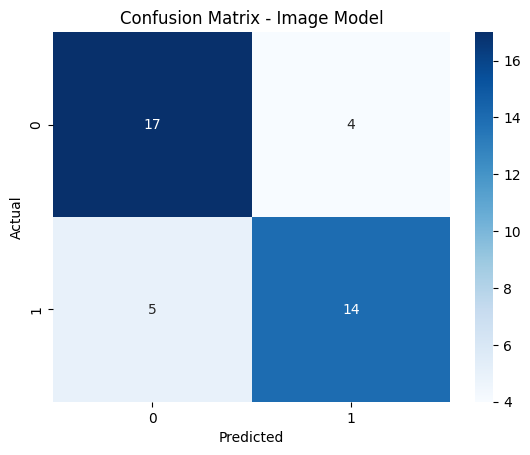

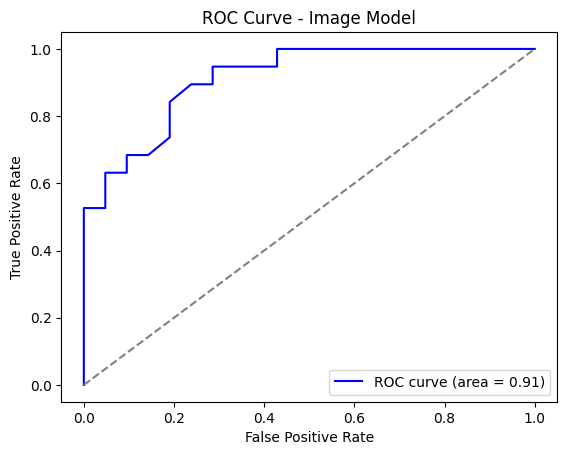

In [ ]:
# Load and preprocess image dataset
images, labels = load_images(image_folder_path)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train and evaluate model for image dataset
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(images.reshape(images.shape[0], -1), labels_encoded, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_img, y_train_img)
image_predictions = rf_model.predict(X_test_img)
print("Image Model Accuracy:", accuracy_score(y_test_img, image_predictions))
print(classification_report(y_test_img, image_predictions))

# Generate Confusion Matrix for Image Model
image_conf_matrix = confusion_matrix(y_test_img, image_predictions)
sns.heatmap(image_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Image Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve for Image Model
fpr_img, tpr_img, _ = roc_curve(y_test_img, rf_model.predict_proba(X_test_img)[:, 1], pos_label=1)
roc_auc_img = auc(fpr_img, tpr_img)
plt.figure()
plt.plot(fpr_img, tpr_img, color='blue', label=f'ROC curve (area = {roc_auc_img:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Image Model')
plt.legend(loc='lower right')
plt.show()